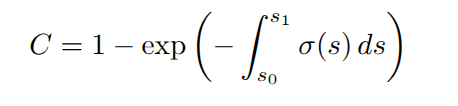

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.random.manual_seed(0)


In [2]:
# import numpy as np
# import matplotlib.pyplot as plt

# def generalized_peak(s: np.ndarray, s0: float, sf: float, width: float):
#     """
#     Symmetric peak function over arbitrary range [s0, sf].

#     Parameters
#     ----------
#     s : np.ndarray
#         Input values.
#     s0 : float
#         Start of the range.
#     sf : float
#         End of the range.
#     width : float
#         Width of the peak (0 < width <= |sf - s0|)

#     Returns
#     -------
#     np.ndarray
#         Output values of the peak function.
#     """
#     c = (s0 + sf) / 2  # center
#     val = 1 - ((2 * (s - c)) / width)**2
#     return np.clip(val, 0, 1)

# # Example usage
# s = np.linspace(0, 2, 500)
# for (s0, sf, w) in [(0.3, 1.7, 1.4), (0.3, 1.7, 0.8), (0.3, 1.7, 0.4)]:
#     y = generalized_peak(s, s0, sf, w)
#     plt.plot(s, y, label=f"s0={s0}, sf={sf}, w={w}")
# plt.title("Generalized Controllable Peak Function")
# plt.xlabel("s")
# plt.ylabel("f(s)")
# plt.legend()
# plt.grid(True)
# plt.show()


In [3]:
s0 = 1
sf = 5
w = 0.5
N = 10
delta = (sf - s0) / N

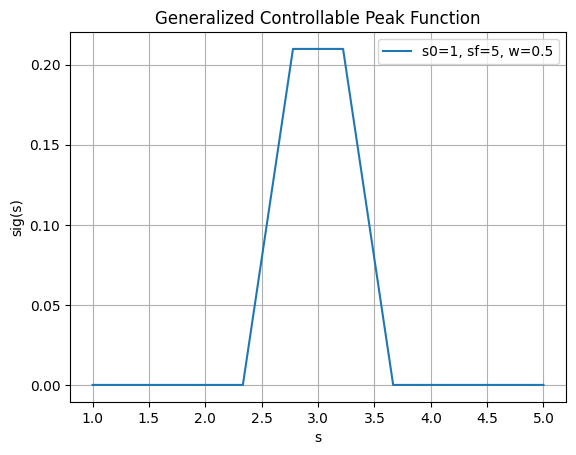

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def get_known_sig(s: np.ndarray, s0: float, sf: float, width: float):
    """
    Symmetric peak function over arbitrary range [s0, sf].

    Parameters
    ----------
    s : np.ndarray
        Input values.
    s0 : float
        Start of the range.
    sf : float
        End of the range.
    width : float
        Width of the peak (0 < width <= |sf - s0|)

    Returns
    -------
    np.ndarray
        Output values of the peak function.
    """
    c = (s0 + sf) / 2  # center
    val = 1 - ((2 * (s - c)) / width)**2
    return torch.clip(val, 0, 1)

# Example usage


s = torch.linspace(s0, sf, N, dtype=torch.float32)
sig = get_known_sig(s, s0, sf, w)
plt.plot(s, sig, label=f"s0={s0}, sf={sf}, w={w}")
    
plt.title("Generalized Controllable Peak Function")
plt.xlabel("s")
plt.ylabel("sig(s)")
plt.legend()
plt.grid(True)
plt.show()


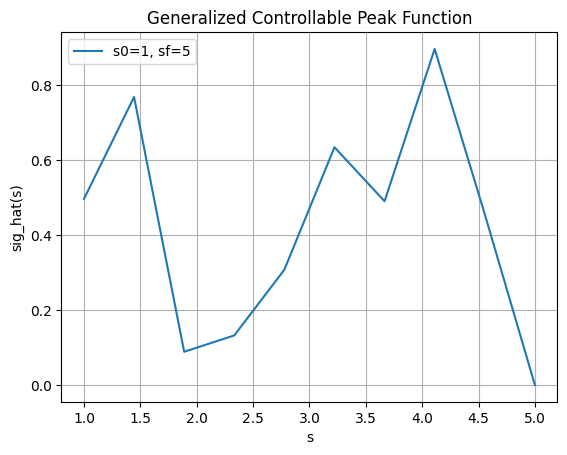

In [5]:
def get_random_sigma(s: np.ndarray, s0: float, sf: float, bins: int = 10, seed: int = 0):
    """
    Generate random values over [s0, sf] using a piecewise constant function.

    Parameters
    ----------
    s : np.ndarray
        Input array of s values.
    s0 : float
        Start of range.
    sf : float
        End of range.
    bins : int
        Number of random segments.
    seed : int
        Random seed.

    Returns
    -------
    np.ndarray
        Random values over [s0, sf].
    """
    edges = torch.linspace(s0, sf, bins + 1)
    values = torch.rand(bins)
    sig = torch.zeros_like(s)
    for i in range(bins):
        sig[(s >= edges[i]) & (s < edges[i+1])] = values[i]
    return sig

sig_rand = get_random_sigma(s, s0, sf, bins  = N, seed = 10)
plt.plot(s, sig_rand, label=f"s0={s0}, sf={sf}")
    
plt.title("Generalized Controllable Peak Function")
plt.xlabel("s")
plt.ylabel("sig_hat(s)")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# print(delta)
# print(sig * delta)
# acc = np.sum(sig*delta)
# print(acc)

# e_acc = np.exp(-acc)
# print(e_acc)

# C = 1 - e_acc
# print(C)

# Lets Focus on this part

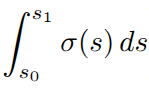

In [7]:
import torch
class tinySigma(torch.nn.Module):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    # self.layer1 = torch.nn.Linear(1, 64)
    # self.relu1 = torch.nn.ReLU() 
    # self.layer2 = torch.nn.Linear(64, 1)
    # self.relu2 = torch.nn.ReLU() 
    self.layers = torch.nn.Sequential(
      torch.nn.Linear(1, 64),
      torch.nn.ReLU(),
      torch.nn.Linear(64, 1),
      # torch.nn.ReLU()
      torch.nn.Softplus()
    )
  def forward(self, x):
    x = self.layers(x.unsqueeze(-1)).squeeze(-1)
    return x

In [8]:
# print(s)
s = s.unsqueeze(0) # [B, N, F = 1]
print(s.shape)
sig = sig.unsqueeze(0) # [B, N, 1]
print(sig.shape)

torch.Size([1, 10])
torch.Size([1, 10])


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)
s = s.to(device)
sig = sig.to(device)


cuda


In [10]:
print(s)
print(sig)

tensor([[1.0000, 1.4444, 1.8889, 2.3333, 2.7778, 3.2222, 3.6667, 4.1111, 4.5556,
         5.0000]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.2099, 0.2099, 0.0000, 0.0000, 0.0000,
         0.0000]], device='cuda:0')


In [11]:
s[0].shape

torch.Size([10])

In [12]:
model = tinySigma()
model = model.to(device)

print(s.shape)
sig_hat = model(s)
print(sig_hat.shape)
print(sig_hat)

torch.Size([1, 10])
torch.Size([1, 10])
tensor([[0.7600, 0.7148, 0.6795, 0.6419, 0.5919, 0.5453, 0.5018, 0.4611, 0.4240,
         0.3933]], device='cuda:0', grad_fn=<SqueezeBackward1>)


In [13]:
# for param in model.parameters():
#   print(param.shape)
#   print(param)


In [14]:
delta

0.4

In [15]:
print(s.shape)
print(sig.shape)
print(model(s).shape)

torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])


In [16]:
def get_c(sig, s):
  C_hat = torch.trapezoid(sig, s, dim=-1)
  return C_hat


In [17]:
print(get_c(sig, s))
print(get_c(model(s), s))

tensor([0.1866], device='cuda:0')
tensor([2.2831], device='cuda:0', grad_fn=<DivBackward1>)


In [18]:
torch.trapezoid(sig, s).shape

torch.Size([1])

In [19]:
import torch.nn.functional as F
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr)
y = get_c(sig, s)
print(y)
epochs = 1000
for step in range(epochs):
  optimizer.zero_grad()
  sig_hat = model(s)
  y_hat = get_c(sig_hat, s)
  loss = F.mse_loss(y_hat, y)
  loss.backward()
  optimizer.step()
  if step % 10 == 0:
    print(f"step: {step:02d} | loss: {loss:+.2f} | y:{y} | y_hat:{y_hat}")
  
    

tensor([0.1866], device='cuda:0')
step: 00 | loss: +4.40 | y:tensor([0.1866], device='cuda:0') | y_hat:tensor([2.2831], device='cuda:0', grad_fn=<DivBackward1>)
step: 10 | loss: +0.02 | y:tensor([0.1866], device='cuda:0') | y_hat:tensor([0.0546], device='cuda:0', grad_fn=<DivBackward1>)
step: 20 | loss: +0.02 | y:tensor([0.1866], device='cuda:0') | y_hat:tensor([0.0566], device='cuda:0', grad_fn=<DivBackward1>)
step: 30 | loss: +0.02 | y:tensor([0.1866], device='cuda:0') | y_hat:tensor([0.0587], device='cuda:0', grad_fn=<DivBackward1>)
step: 40 | loss: +0.02 | y:tensor([0.1866], device='cuda:0') | y_hat:tensor([0.0609], device='cuda:0', grad_fn=<DivBackward1>)
step: 50 | loss: +0.02 | y:tensor([0.1866], device='cuda:0') | y_hat:tensor([0.0633], device='cuda:0', grad_fn=<DivBackward1>)
step: 60 | loss: +0.01 | y:tensor([0.1866], device='cuda:0') | y_hat:tensor([0.0658], device='cuda:0', grad_fn=<DivBackward1>)
step: 70 | loss: +0.01 | y:tensor([0.1866], device='cuda:0') | y_hat:tensor([

In [20]:
sig_hat = model(s)
y_hat = get_c(sig_hat, s)
print(f"Sigma True: {sig}")
print(f"Sigma predicted: {sig_hat}")
print(f"True: {y}")
print(f"Predicted: {y_hat}")

Sigma True: tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.2099, 0.2099, 0.0000, 0.0000, 0.0000,
         0.0000]], device='cuda:0')
Sigma predicted: tensor([[0.2571, 0.1403, 0.0749, 0.0387, 0.0192, 0.0095, 0.0047, 0.0023, 0.0012,
         0.0006]], device='cuda:0', grad_fn=<SqueezeBackward1>)
True: tensor([0.1866], device='cuda:0')
Predicted: tensor([0.1866], device='cuda:0', grad_fn=<DivBackward1>)


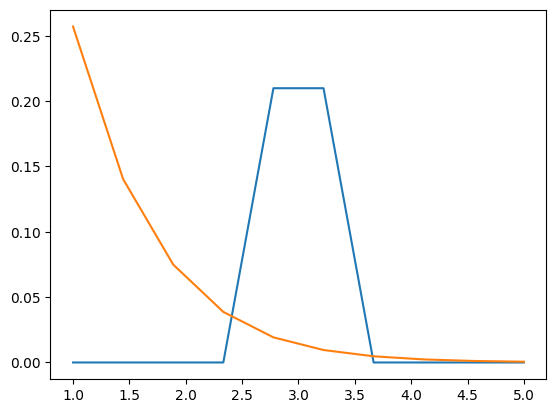

In [21]:
idx = 0
plt.plot(s[idx].detach().cpu().numpy(), sig[idx].detach().cpu().numpy());
plt.plot(s[idx].detach().cpu().numpy(), sig_hat[idx].detach().cpu().numpy());

In [22]:
(sig_hat*0.44).sum()

tensor(0.2414, device='cuda:0', grad_fn=<SumBackward0>)

In [23]:
# print(s.device)
# print(sig.device)
# print(sig_hat.device)

In [24]:
# for param in model.parameters():
#   print(param.shape)
#   print(param)


## The conclstion: I learned C but the hidden sigma not match